# Predictive Analysis for Optimal Fertilizer

# Import Library

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc

# data preparation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# model development
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Data Understanding


Dataset yang digunakan dalam proyek ini berasal dari kompetisi Kaggle berjudul [Predicting Optimal Fertilizers - Playground Series S5E6](https://www.kaggle.com/competitions/playground-series-s5e6).  
Dataset ini berisi data kuantitatif yang bertujuan untuk memprediksi jenis pupuk (fertilizer) yang optimal berdasarkan sejumlah fitur numerik dan kategorikal.




## Data Loading

In [2]:
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c playground-series-s5e6

  0% 0.00/11.7M [00:00<?, ?B/s]
100% 11.7M/11.7M [00:00<00:00, 890MB/s]


In [4]:
!unzip playground-series-s5e6.zip

Archive:  playground-series-s5e6.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
# Tampilkan DataFrame sample submission
sample_submission

,id,Fertilizer Name
0,750000,14-35-14 10-26-26 Urea
1,750001,14-35-14 10-26-26 Urea
2,750002,14-35-14 10-26-26 Urea
3,750003,14-35-14 10-26-26 Urea
4,750004,14-35-14 10-26-26 Urea
...,...,...
249995,999995,14-35-14 10-26-26 Urea
249996,999996,14-35-14 10-26-26 Urea
249997,999997,14-35-14 10-26-26 Urea
249998,999998,14-35-14 10-26-26 Urea


In [7]:
# Tampilkan DataFrame train
train

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP
...,...,...,...,...,...,...,...,...,...,...
749995,749995,25,69,30,Clayey,Maize,8,16,6,28-28
749996,749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17
749997,749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26
749998,749998,31,68,29,Red,Cotton,9,11,12,20-20


In [8]:
# Tampilkan DataFrame test
test

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14
...,...,...,...,...,...,...,...,...,...
249995,999995,26,66,30,Red,Sugarcane,14,7,18
249996,999996,33,62,55,Red,Pulses,28,14,7
249997,999997,36,53,64,Black,Paddy,28,11,27
249998,999998,36,67,26,Clayey,Paddy,33,0,10


Data dibagi menjadi dua bagian utama:
- `train.csv`: Data latih yang berisi 750.000 baris dan 10 kolom fitur dan label target `Fertilizer Name`.
- `test.csv`: Data uji tanpa label target berisi 250.000 baris dan 9 kolom (tanpa kolom target), yang akan digunakan untuk melakukan prediksi.
- `sample_submission.csv`: Contoh format file prediksi untuk proses submission.


# Exploratory Data Analysis

In [9]:
# Tampilkan informasi umum tentang dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


Dari output terlihat bahwa:

- Terdapat **3 kolom dengan tipe data `object`**, yaitu:
  - `Soil Type`, `Crop Type`, dan `Fertilizer Name`.  
    Kolom-kolom ini merupakan **fitur kategorikal** (non-numerik).
- Terdapat **7 kolom dengan tipe data numerik `int64`**, yaitu:
  - `id`, `Temparature`, `Humidity`, `Moisture`, `Nitrogen`, `Potassium`, dan `Phosphorous`.  
    Kolom-kolom ini merupakan **fitur numerik** yang mengandung nilai kuantitatif dari karakteristik tanah, cuaca, dan nutrisi.
- Kolom `Fertilizer Name` adalah **target variabel** yang ingin diprediksi dalam proyek ini.
- Tidak ada kolom missing value dalam dataset


In [10]:
train.describe()

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,216506.495284,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,187499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,374999.500000,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,562499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,749999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


- Sebagian besar fitur numerik memiliki skala dan distribusi (min–max) yang berbeda, terutama pada fitur Nitrogen (4–42), Potassium (0–19), dan Phosphorous (0–42) yang menunjukkan rentang nilai yang cukup luas dan bervariasi.

- Fitur cuaca seperti Temparature (25–38), Humidity (50–72), dan Moisture (25–65) memiliki distribusi yang relatif stabil dan normal.

- Karena skala antar fitur tidak seragam, normalisasi atau standarisasi perlu dipertimbangkan agar model dapat belajar secara seimbang dan akurat.

## Memeriksa Outliers

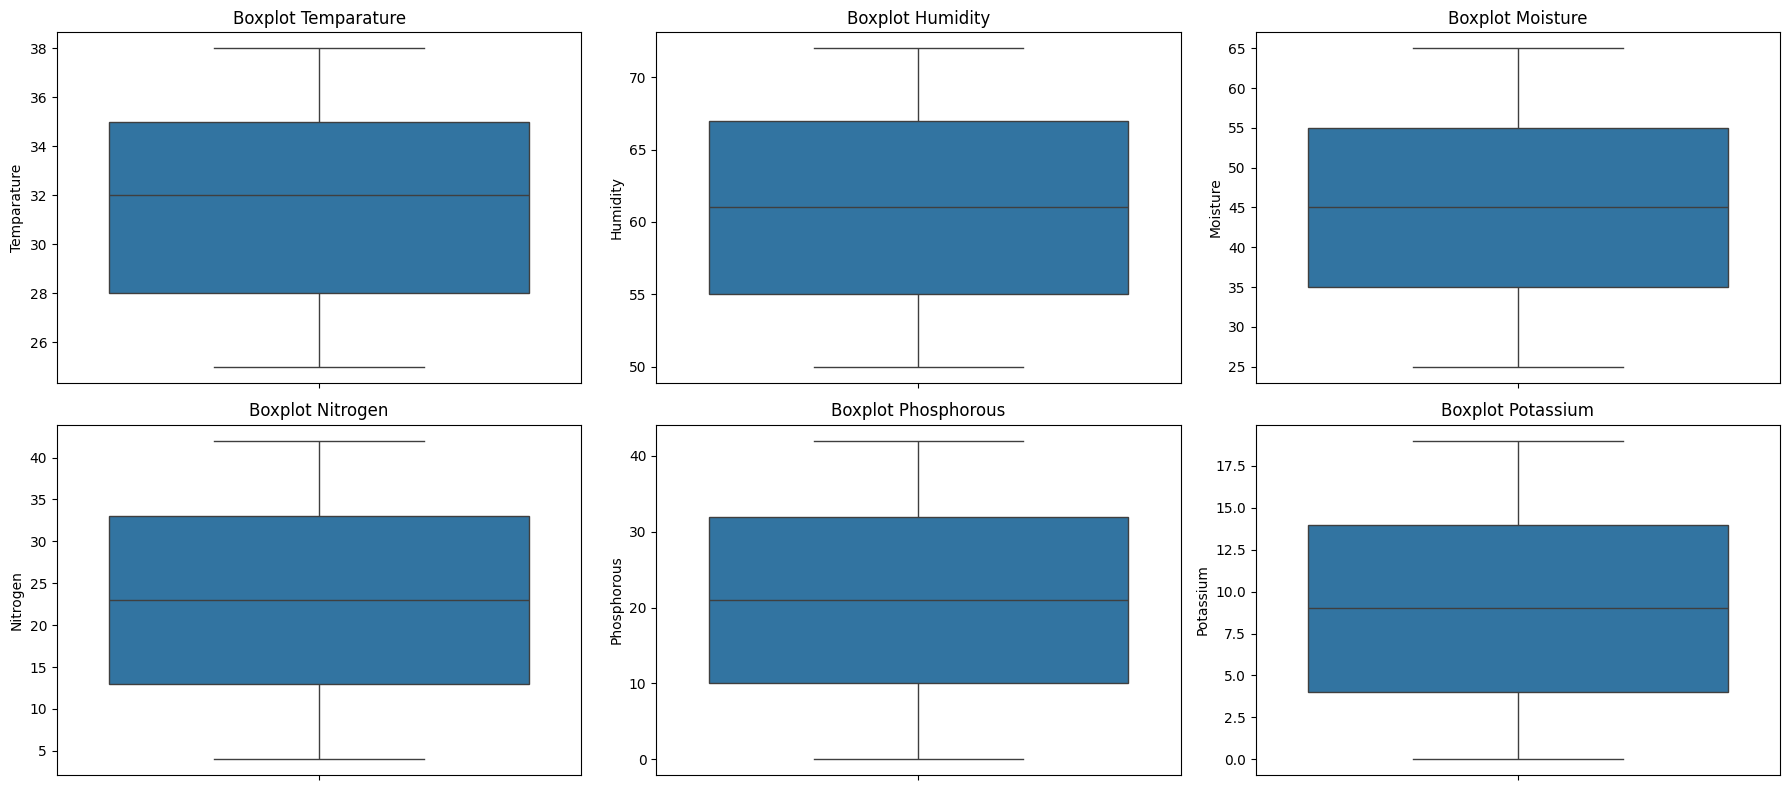

Temparature:
  Q1 = 28.000, Q3 = 35.000, IQR = 7.000
  Lower bound = 17.500, Upper bound = 45.500
  Jumlah outlier = 0 dari total 750000 data

Humidity:
  Q1 = 55.000, Q3 = 67.000, IQR = 12.000
  Lower bound = 37.000, Upper bound = 85.000
  Jumlah outlier = 0 dari total 750000 data

Moisture:
  Q1 = 35.000, Q3 = 55.000, IQR = 20.000
  Lower bound = 5.000, Upper bound = 85.000
  Jumlah outlier = 0 dari total 750000 data

Nitrogen:
  Q1 = 13.000, Q3 = 33.000, IQR = 20.000
  Lower bound = -17.000, Upper bound = 63.000
  Jumlah outlier = 0 dari total 750000 data

Phosphorous:
  Q1 = 10.000, Q3 = 32.000, IQR = 22.000
  Lower bound = -23.000, Upper bound = 65.000
  Jumlah outlier = 0 dari total 750000 data

Potassium:
  Q1 = 4.000, Q3 = 14.000, IQR = 10.000
  Lower bound = -11.000, Upper bound = 29.000
  Jumlah outlier = 0 dari total 750000 data



In [11]:
numerical_features = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Phosphorous', 'Potassium']

# Memvisualisasikan data dengan boxplot untuk mendeteksi outliers pada fitur numerik
plt.figure(figsize=(18, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=train[feature])
    plt.title(f'Boxplot {feature}')
plt.tight_layout()
plt.show()

# Deteksi outlier menggunakan IQR
for feature in numerical_features:
    Q1 = train[feature].quantile(0.25)
    Q3 = train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train[(train[feature] < lower_bound) | (train[feature] > upper_bound)]
    print(f"{feature}:")
    print(f"  Q1 = {Q1:.3f}, Q3 = {Q3:.3f}, IQR = {IQR:.3f}")
    print(f"  Lower bound = {lower_bound:.3f}, Upper bound = {upper_bound:.3f}")
    print(f"  Jumlah outlier = {outliers.shape[0]} dari total {train.shape[0]} data\n")

- Tidak ditemukan outlier pada keenam fitur yang dianalisis

## Univariate Analysis

Melakukan proses analisis data dengan teknik Univariate EDA yang fokus pada satu variabel (fitur) saja untuk memahami karakteristik dasarnya. Pertama, membagi fitur pada dataset menjadi dua bagian, yaitu numerical features dan categorical features.

In [12]:
numerical_features = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Phosphorous', 'Potassium']
categorical_features = ['Soil Type', 'Crop Type', 'Fertilizer Name']

### Categorical Features

           jumlah sampel  persentase
Soil Type                           
Sandy             156710        20.9
Black             150956        20.1
Clayey            148382        19.8
Red               148102        19.7
Loamy             145850        19.4


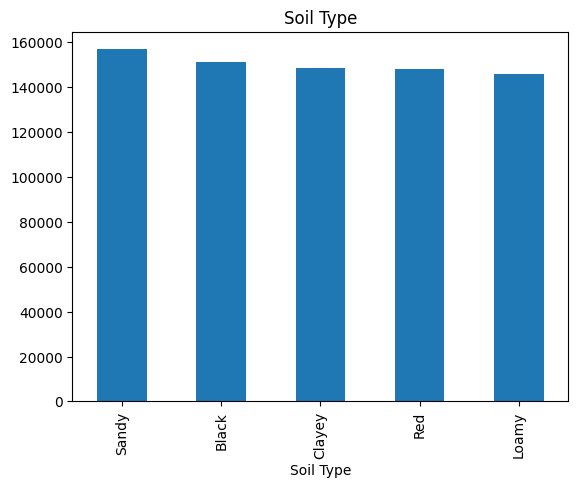

In [13]:
# Memvisualisasikan fitur Soil Type
feature = categorical_features[0]
count = train[feature].value_counts()
percent = 100*train[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df)
count.plot(kind='bar', title=feature);

             jumlah sampel  persentase
Crop Type                             
Paddy                85754        11.4
Pulses               78180        10.4
Cotton               69171         9.2
Tobacco              68000         9.1
Wheat                66628         8.9
Millets              65291         8.7
Barley               65045         8.7
Sugarcane            64269         8.6
Oil seeds            64184         8.6
Maize                62569         8.3
Ground Nuts          60909         8.1


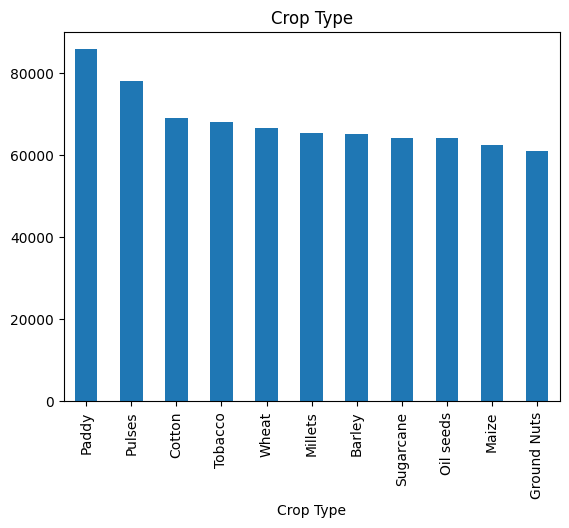

In [14]:
# Memvisualisasikan fitur Crop Type
feature = categorical_features[1]
count = train[feature].value_counts()
percent = 100*train[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df)
count.plot(kind='bar', title=feature);

                 jumlah sampel  persentase
Fertilizer Name                           
14-35-14                114436        15.3
10-26-26                113887        15.2
17-17-17                112453        15.0
28-28                   111158        14.8
20-20                   110889        14.8
DAP                      94860        12.6
Urea                     92317        12.3


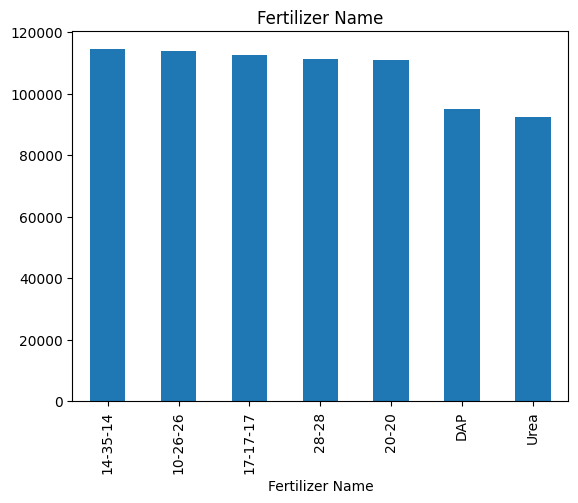

In [15]:
# Memvisualisasikan fitur Fertilizer Name
feature = categorical_features[2]
count = train[feature].value_counts()
percent = 100*train[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df)
count.plot(kind='bar', title=feature);

### Numerical Feature

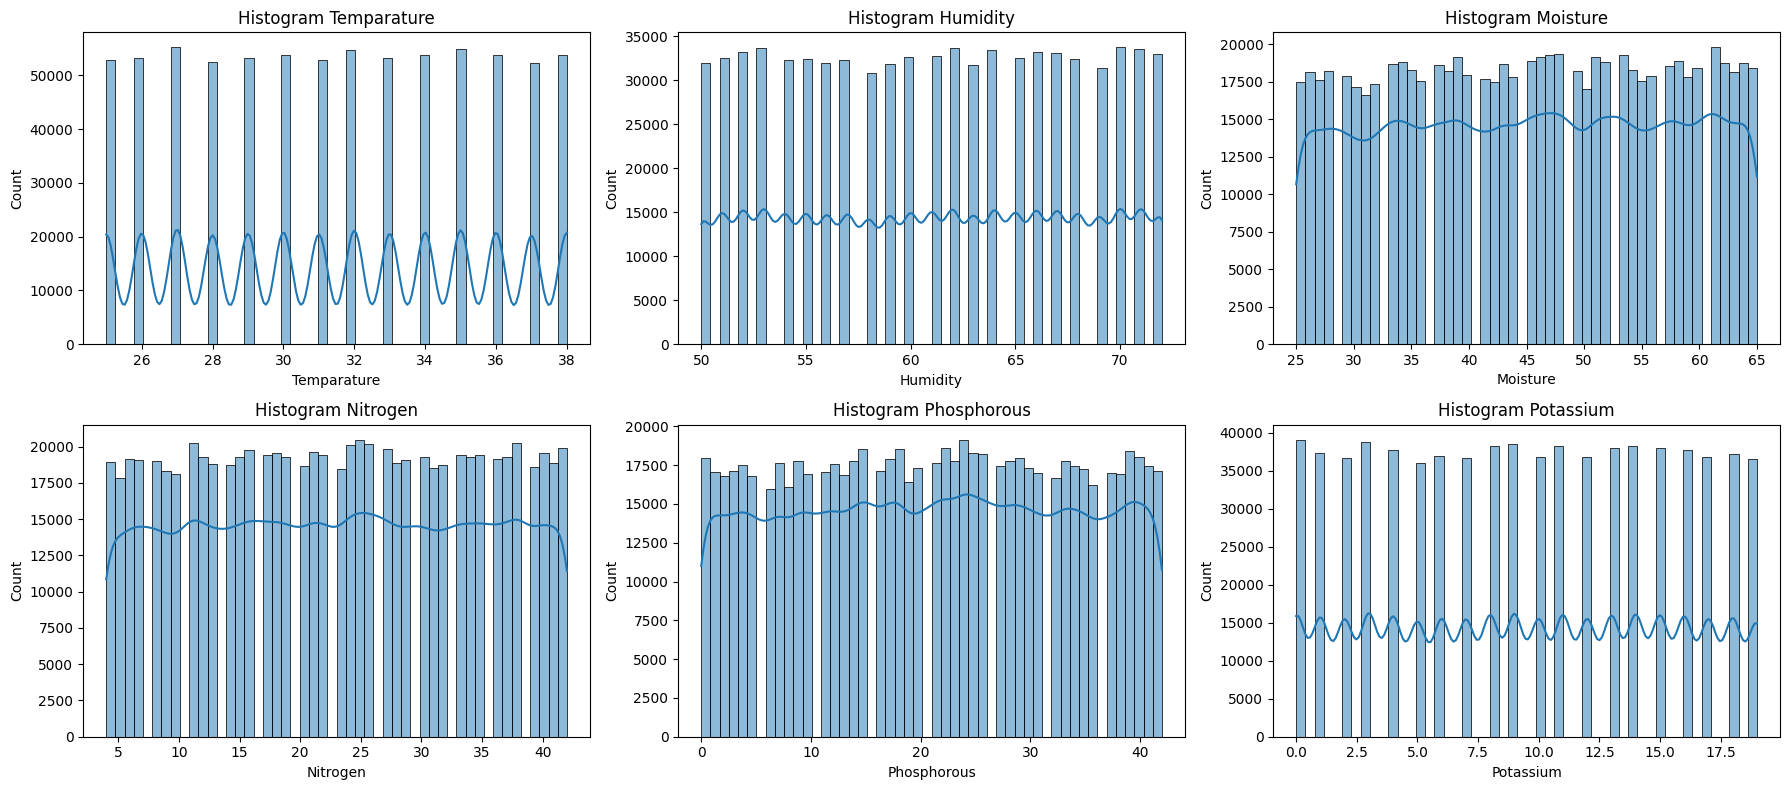

In [16]:
# Memvisualisasikan numerical fitur dengan Histogram
plt.figure(figsize=(18, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train[feature], bins=50, kde=True)
    plt.title(f'Histogram {feature}')
plt.tight_layout()
plt.show()

## Multivariate Analysis

Multivariate EDA menunjukkan hubungan antara dua atau lebih variabel pada data. Multivariate EDA yang menunjukkan hubungan antara dua variabel biasa disebut sebagai bivariate EDA.

## Categorical Features
Melihat rata-rata nilai numerik terhadap setiap kategori pada fitur kategorikal, yaitu Soil Type dan Crop Type, terhadap target klasifikasi Fertilizer Name.

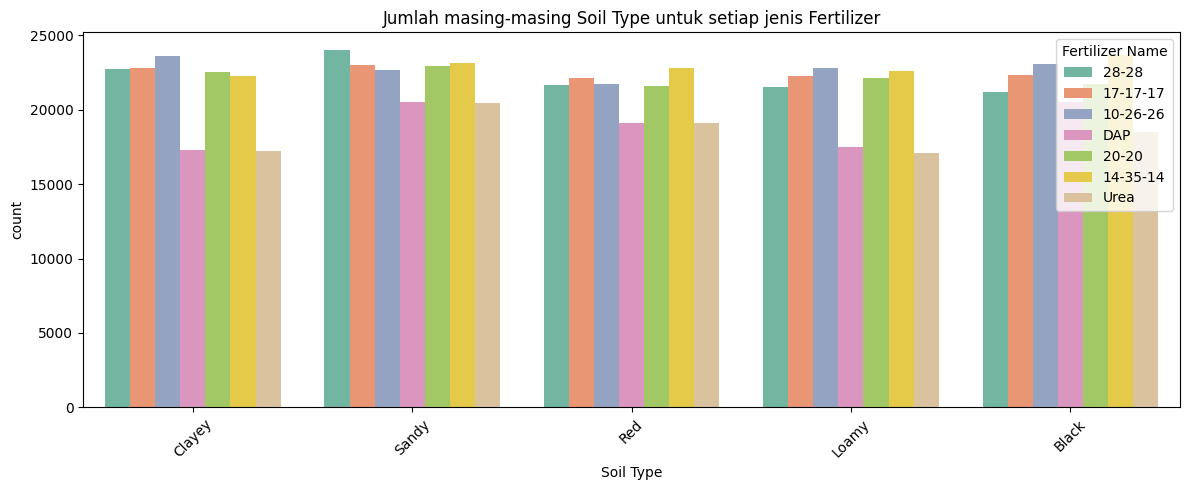

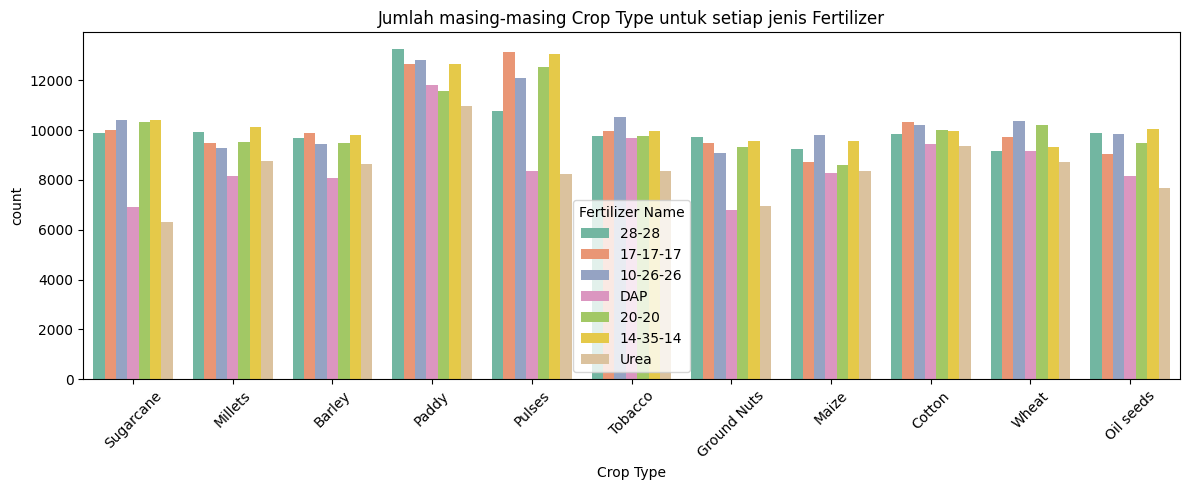

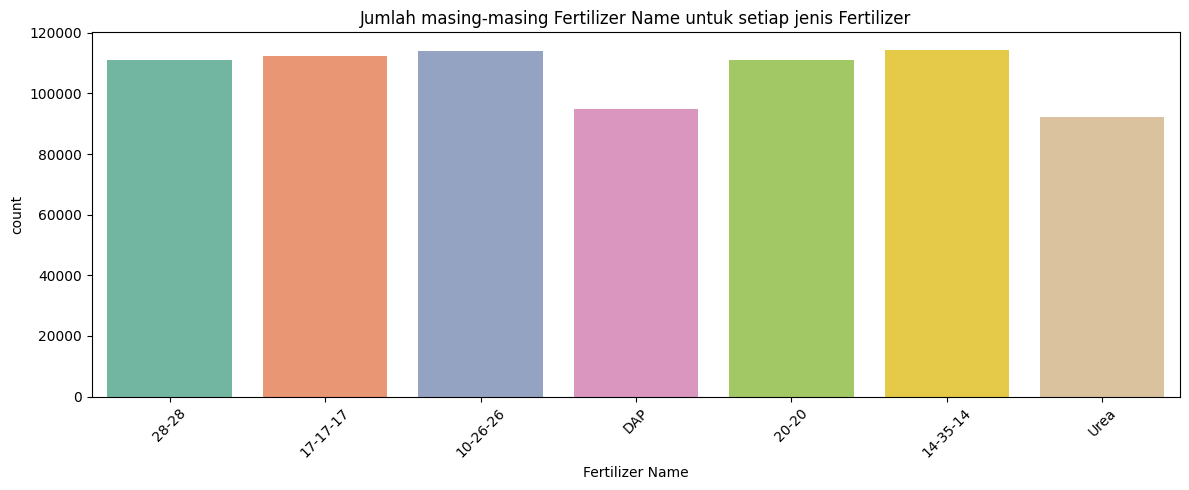

In [17]:
# Loop untuk visualisasi
for col in categorical_features:
    plt.figure(figsize=(12, 5))
    sns.countplot(x=col, hue="Fertilizer Name", data=train, palette="Set2")
    plt.title(f'Jumlah masing-masing {col} untuk setiap jenis Fertilizer')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Numerical Features
- Melihat hubungan antar fitur numerik dengan pairplot
- Mengamati korelasi antar fitur numerik menggunakan heatmap

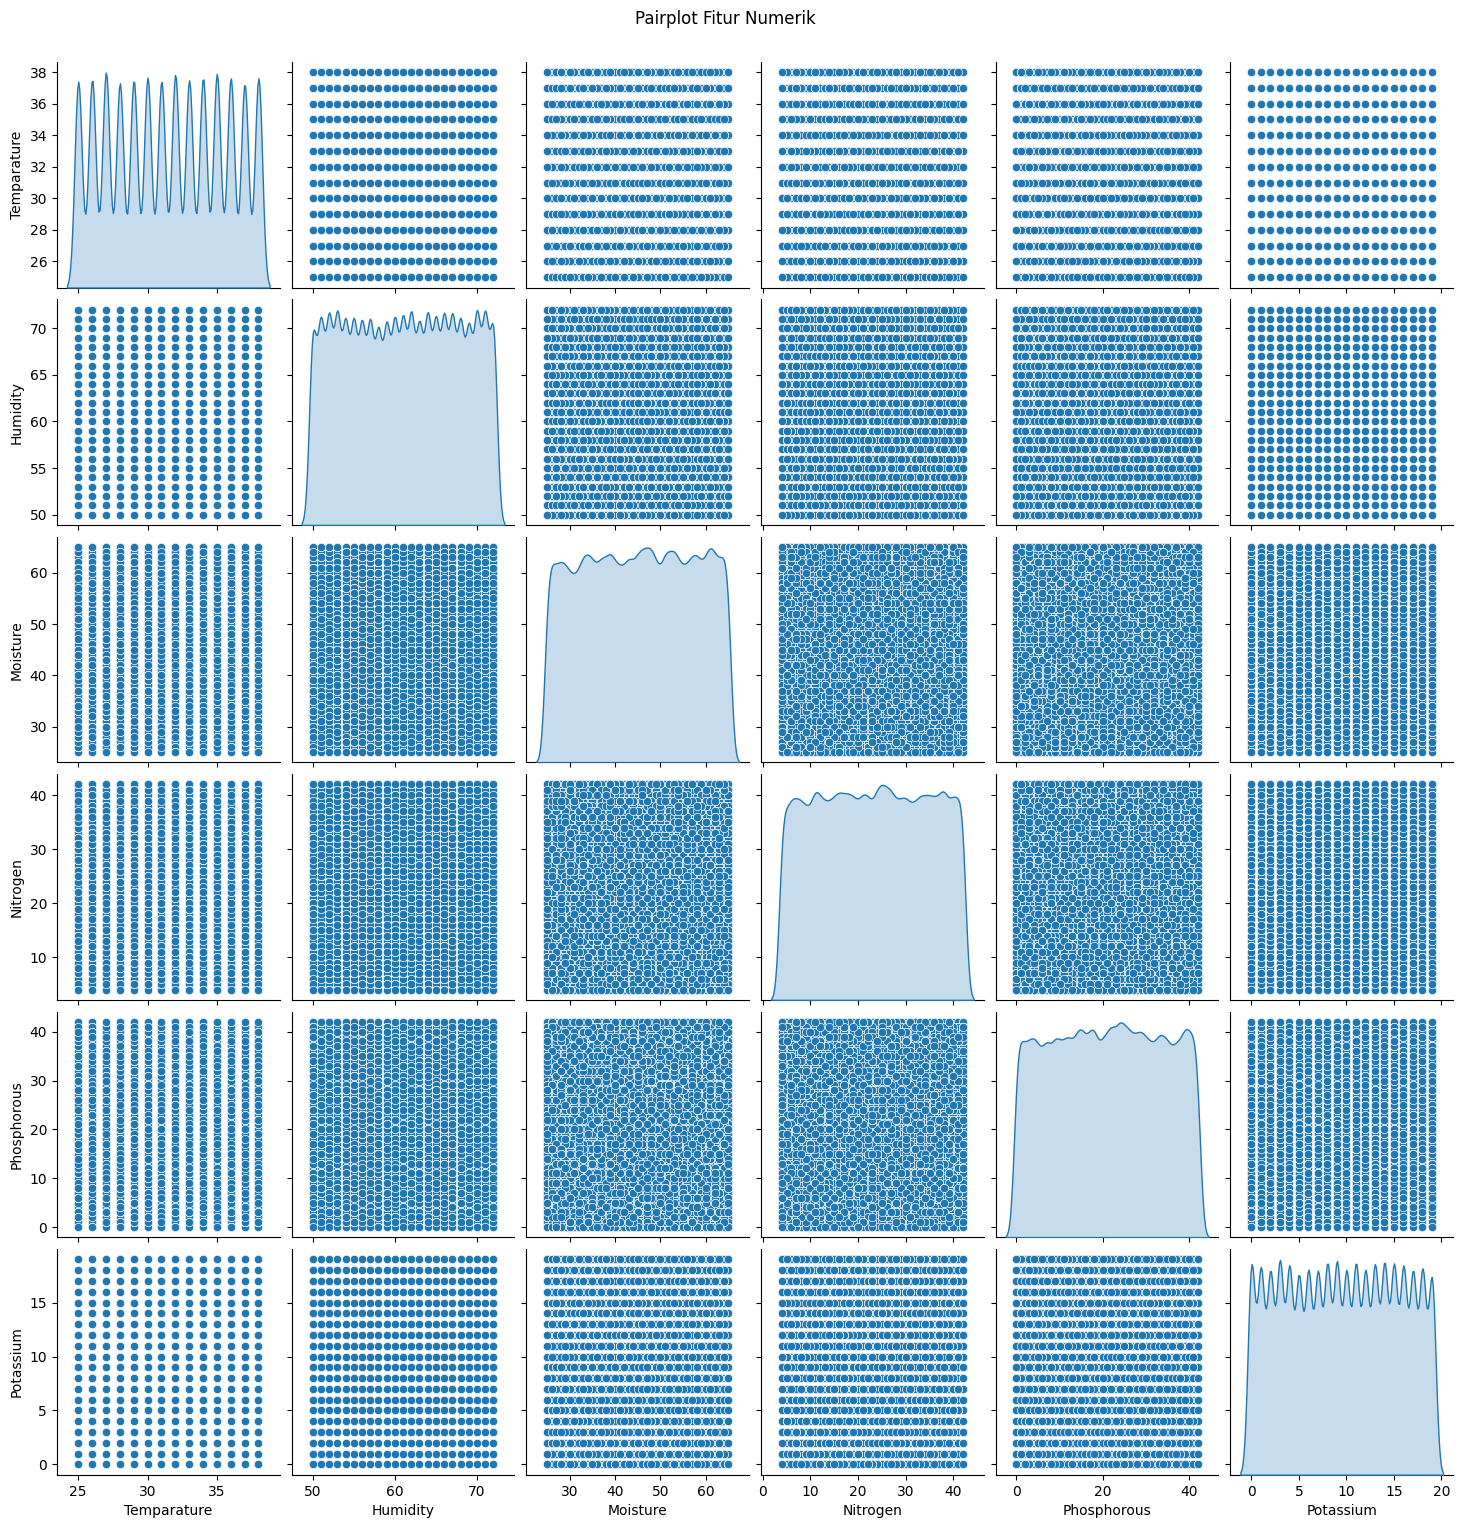

In [18]:
# Pairplot antar fitur numerik
sns.pairplot(train[numerical_features], diag_kind='kde')
plt.suptitle("Pairplot Fitur Numerik", y=1.02)
plt.show()

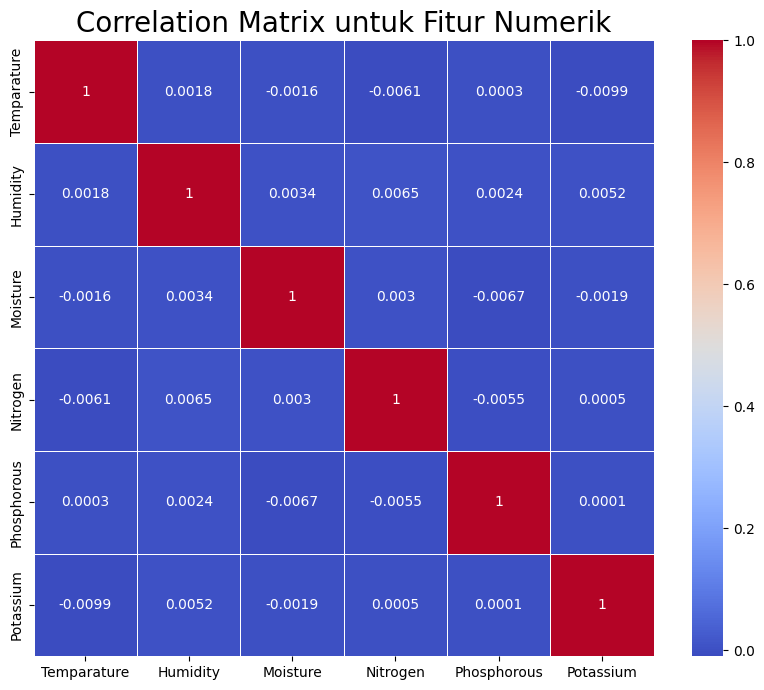

In [19]:
# Korelasi antar fitur numerik
plt.figure(figsize=(10, 8))
correlation_matrix = train[numerical_features].corr().round(4)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix untuk Fitur Numerik", size=20)
plt.show()

# Data Preparation

## Encoding fitur kategori
Mngubah kolom kategorikal (Soil Type, Crop Type, Fertilizer Name) menjadi numerik agar bisa digunakan dalam model.

Untuk fitur:
- Gunakan One-Hot Encoding pada fitur input kategorikal.
- Gunakan Label Encoding pada target (Fertilizer_Name).

In [20]:
# Pisahkan fitur dan target data train
X = train.drop(['id', 'Fertilizer Name'], axis=1)
y = train['Fertilizer Name']

In [21]:
# Encoding fitur kategorikal (Soil Type dan Crop Type) menggunakan one-hot encoding
X_encoded = pd.get_dummies(X, columns=['Soil Type', 'Crop Type'])
test_encoded = pd.get_dummies(test.drop(['id'], axis=1), columns=['Soil Type', 'Crop Type'])

In [22]:
# Pastikan kolom antara train dan test sama (align kolom)
X_encoded, test_encoded = X_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

In [23]:
X_encoded

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Soil Type_Black,Soil Type_Clayey,Soil Type_Loamy,Soil Type_Red,...,Crop Type_Cotton,Crop Type_Ground Nuts,Crop Type_Maize,Crop Type_Millets,Crop Type_Oil seeds,Crop Type_Paddy,Crop Type_Pulses,Crop Type_Sugarcane,Crop Type_Tobacco,Crop Type_Wheat
0,37,70,36,36,4,5,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,27,69,65,30,6,18,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,29,63,32,24,12,16,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,35,62,54,39,12,4,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,35,58,43,37,2,16,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,25,69,30,8,16,6,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
749996,37,64,58,38,8,20,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
749997,35,68,59,6,11,29,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
749998,31,68,29,9,11,12,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False


In [24]:
test_encoded

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Soil Type_Black,Soil Type_Clayey,Soil Type_Loamy,Soil Type_Red,...,Crop Type_Cotton,Crop Type_Ground Nuts,Crop Type_Maize,Crop Type_Millets,Crop Type_Oil seeds,Crop Type_Paddy,Crop Type_Pulses,Crop Type_Sugarcane,Crop Type_Tobacco,Crop Type_Wheat
0,31,70,52,34,11,24,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,27,62,45,30,14,15,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,28,72,28,14,15,4,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
3,37,53,57,18,17,36,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,31,55,32,13,19,14,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,26,66,30,14,7,18,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
249996,33,62,55,28,14,7,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
249997,36,53,64,28,11,27,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
249998,36,67,26,33,0,10,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False


In [25]:
# Encode label (target)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## Standardisasi
Gunakan StandardScaler agar semua fitur numerik berada dalam skala yang sama

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
test_scaled = scaler.transform(test_encoded)

## Split Data Validasi
Untuk evaluasi MAP@3 di lokal, tidak bisa langsung mengevaluasi MAP@3 pada data test (karena label test tidak diketahui)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Model Development

Pada tahap ini dilakukan pelatihan dan evaluasi beberapa model klasifikasi, yaitu XGBoost, Random Forest, dan LightGBM, untuk memprediksi jenis pupuk berdasarkan fitur cuaca, tanah, dan tanaman.

Dataset `train` dibagi menjadi `train` dan `validation` set untuk mengevaluasi performa model secara objektif menggunakan metrik `MAP@3`. Mean Average Precision (MAP) adalah metrik evaluasi yang digunakan untuk mengukur seberapa baik model dalam memberi peringkat label yang benar di posisi teratas dari beberapa kemungkinan,  untuk tugas klasifikasi multilabel/multiclass, berbasis ranking.

Model terbaik dipilih berdasarkan skor MAP@3 tertinggi pada data validasi dan digunakan untuk menghasilkan prediksi akhir pada data test.

## Fungsi MAP@3

In [28]:
# Fungsi MAP@3
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
       # Convert the numpy array slice to a list before using the index method
        p_list = list(p[:k])
        if a in p_list:
            return 1.0 / (p_list.index(a) + 1)
        return 0.0
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

## Fungsi evaluasi model

In [29]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_val)
    top_3 = np.argsort(probs, axis=1)[:, -3:][:, ::-1]
    score = mapk(y_val, top_3, k=3)
    print(f"{name:<20}: MAP@3 = {score:.4f}")
    return score

In [30]:
# Evaluasi semua model
scores = {}

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
scores['XGBoost'] = evaluate_model(xgb_model, "XGBoost")

# Bersihkan memori
del xgb_model
gc.collect()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:21:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost             : MAP@3 = 0.3307


15886

In [31]:
# RandomForest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
scores['Random Forest'] = evaluate_model(rf_model, "Random Forest")

# Bersihkan memori
del rf_model
gc.collect()

Random Forest       : MAP@3 = 0.2911


103846

In [32]:
# LightGBM Classifier
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
scores['LightGBM'] = evaluate_model(lgbm_model, "LightGBM")

# Bersihkan memori
del lgbm_model
gc.collect()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 22
[LightGBM] [Info] Start training from score -1.885565
[LightGBM] [Info] Start training from score -1.877350
[LightGBM] [Info] Start training from score -1.900582
[LightGBM] [Info] Start training from score -1.909654
[LightGBM] [Info] Start training from score -1.910836
[LightGBM] [Info] Start training from score -2.069993
[LightGBM] [Info] Start training from score -2.091474


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM            : MAP@3 = 0.3230


4

In [33]:
scores

{'XGBoost': np.float64(0.33067),
 'Random Forest': np.float64(0.2911188888888889),
 'LightGBM': np.float64(0.3229622222222222)}

# Prediction

## Model final

Model final dengan nilai MAP tertinggi merupakan XGBoost             : MAP@3 = 0.3307

Sehingga XGBoost akan dilatih ulang untuk proses prediksi pada data test.

In [34]:
# Latih ulang model terbaik dengan data test
final_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
final_model.fit(X_scaled, y_encoded)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:25:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
# Prediksi probabilitas untuk data test
test_probs = final_model.predict_proba(test_scaled)

# Ambil 3 label dengan probabilitas tertinggi:
top_3_preds_idx = np.argsort(test_probs, axis=1)[:, -3:][:, ::-1]  # top-3 indeks terurut
# Ubah indeks ke label asli
top_3_preds_label = le.inverse_transform(top_3_preds_idx.ravel()).reshape(top_3_preds_idx.shape)

# Submission.csv
Buat DataFrame submission dan simpan jadi submission.csv


In [36]:
# Format prediksi jadi string space-delimited
submission_preds = [' '.join(row) for row in top_3_preds_label]

In [37]:
submission = pd.DataFrame({
    'id': test['id'],  # pastikan kolom id sesuai
    'Fertilizer Name': submission_preds
})

submission.to_csv('submission.csv', index=False)
print("submission.csv berhasil dibuat.")

submission.csv berhasil dibuat.


In [38]:
submission = pd.read_csv('submission.csv')
submission

,id,Fertilizer Name
0,750000,DAP 28-28 Urea
1,750001,17-17-17 20-20 10-26-26
2,750002,28-28 20-20 14-35-14
3,750003,14-35-14 Urea 17-17-17
4,750004,20-20 10-26-26 28-28
...,...,...
249995,999995,17-17-17 14-35-14 28-28
249996,999996,14-35-14 10-26-26 17-17-17
249997,999997,14-35-14 DAP Urea
249998,999998,17-17-17 10-26-26 28-28
